In [58]:
import numpy as np
import matplotlib.pyplot as plt

from desc.continuation import solve_continuation_automatic
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import Grid, _periodic_spacing
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    BallooningStability,
    EffectiveRadius,
)
from desc.optimize import Optimizer

In [32]:
eq_fam_HSX = desc.io.load("/home/jjfrybes/DESC/desc/examples/HSX_output.h5")
eq = eq_fam_HSX[-1]
# it will be helpful to store intermediate results
eqfam = EquilibriaFamily(eq)

In [20]:
# Function to get value of a parameter directly
def get_value(eq,name,grid):
    return eq.compute(name,grid=grid)[name]

# Function to get the straight field line coordinate system
def get_field_line_grid(eq,rho=0.5,alpha=0,n_pol = 4,n_points = 200):
    # Get initial grid to get iota value
    initial_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        np.array(0),
        coordinates="raz",
        period=(np.inf,2*np.pi,np.inf)
    )
    iota = np.abs(get_value(eq,"iota",initial_grid)[1])
    NFP = eq.NFP
    n_tor = n_pol/(iota*NFP)
    good_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        coordinates="raz",
        period=(np.inf,2*np.pi,np.inf),
    )
    return good_grid

In [64]:
def run_step(k, eq):
    """Run a step of the precise QH optimization example from Landreman & Paul."""

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    # grid = get_field_line_grid(eq,n_pol=10)

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            # EffectiveRadius(eq=eq, grid=grid),
            BallooningStability(eq=eq),
            # try to keep the aspect ratio about the same
            # AspectRatio(eq=eq, target=8, weight=100),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("fmin-auglag-bfgs")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

Values of R_eff are [5.546296297908115, 5.3222720115595115, 4.553797170371179, 5.723048768086856, 4.458054267576598, 3.7969065651341847]
Values of a/R_eff are [0.02190828 0.02283044 0.02668318 0.02123166 0.02725624 0.03200232]


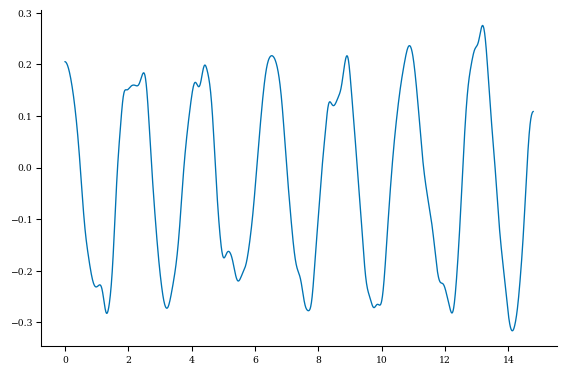

In [43]:
grid = get_field_line_grid(eq,n_pol=10);
Kd = get_value(eq,"K_d",grid)
plt.figure()
plt.plot(grid.nodes[:,2],Kd)
R_eff = get_value(eq,"R_eff",grid)
a = get_value(eq,"a",grid)
print(f"Values of R_eff are {R_eff}")
print(f"Values of a/R_eff are {np.divide(a,R_eff)}")

In [53]:
rho = np.array(0.5)
alpha = np.array(0)
n_tor = 10
zeta = np.linspace(0,2*np.pi*n_tor,100*n_tor)
grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf),
    )

In [68]:
eq1 = run_step(1, eq)
eqfam.append(eq1)

Building objective: ideal ballooning lambda


Timer: Objective build = 5.38 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 470 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 181 ms
Timer: Objective build = 220 ms
Timer: Linear constraint projection build = 891 ms
Timer: Linear constraint projection build = 615 ms
Number of parameters: 1900
Number of objectives: 1
Number of equality constraints: 5000
Number of inequality constraints: 0
Timer: Initializing the optimization = 7.62 sec

Starting optimization
Using method: fmin-auglag-bfgs


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape int64[777]
The error occurred while tracing the function compute_scaled_error at /home/jjfrybes/DESC/desc/objectives/objective_funs.py:1094 for jit. 
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError